<a href="https://colab.research.google.com/github/vijaygwu/advertising/blob/main/Attribution_Markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is a **section-by-section** explanation of the enhanced code for your **Markov Attribution** model in an e-commerce context. The script accomplishes the following:

1. **Generates synthetic e-commerce journeys** (multiple channels, conversion events).  
2. **Builds a Markov chain** to model how users move from one channel to the next.  
3. **Computes attribution** based on channel “removal effects.”  
4. **Outputs** performance metrics and **visualizations** of channel effectiveness.

---

## 1. **Imports and Global Definitions**

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Tuple, Dict, Any
from collections import defaultdict
```

- **numpy** and **pandas**: For numerical computation and DataFrame manipulation.  
- **matplotlib.pyplot** and **seaborn**: For plotting and data visualization.  
- **datetime** and **timedelta**: To handle timestamps in the synthetic journeys.  
- **typing**: Provides type hints (`List`, `Tuple`, `Dict`, `Any`) for better code clarity.  
- **collections.defaultdict**: Not heavily used in this script, but useful for data structures with default values.

---

## 2. **MarkovAttributionModel Class**

### Overview
The `MarkovAttributionModel` handles the core Markov chain logic. It:

1. Creates a **transition matrix** from a list of journeys.  
2. Computes the **overall conversion probability**.  
3. Evaluates **removal effects** for channels to measure how much each channel contributes to conversion.

```python
class MarkovAttributionModel:
    """
    A Markov-based approach to channel attribution.

    This class builds a transition matrix from a set of customer journeys.
    Each journey is a list of channel names (plus a 'conversion' label at the end if applicable).
    
    States:
      - 'start': Beginning of the journey
      - 'conversion': Absorbing state if the customer converts
      - 'null': Absorbing state if the customer does not convert
      - Other channels: Non-absorbing states

    The model calculates an overall conversion probability and
    computes removal effects to determine the contribution of each channel.
    """

    def __init__(self, max_iterations: int = 500, tolerance: float = 1e-7) -> None:
        """
        Parameters
        ----------
        max_iterations : int
            Maximum number of iterations for the iterative state update.
        tolerance : float
            Convergence threshold for iterative Markov chain probability updates.
        """
        self.transition_matrix: np.ndarray | None = None
        self.channels: List[str] | None = None
        self.removal_effects: Dict[str, float] = {}
        self.max_iterations = max_iterations
        self.tolerance = tolerance
```

- **`__init__`**:  
  - `max_iterations`: Maximum times we will iterate when calculating the steady-state probabilities.  
  - `tolerance`: Threshold for determining convergence (if the probability distribution changes less than `tolerance`, we assume it’s converged).  
  - `transition_matrix`, `channels`, `removal_effects`: Will be populated later.

---

### 2.1 `_create_transition_matrix(...)`

```python
    def _create_transition_matrix(self, journeys: List[List[str]]) -> np.ndarray:
        """
        Build a transition probability matrix from a list of journeys.
        ...
        """
        # Collect all channels, plus the special states
        all_channels = {'start', 'conversion', 'null'}
        for journey in journeys:
            all_channels.update(journey)

        # Sort channels for consistency
        self.channels = sorted(all_channels)
        channel_to_idx = {ch: i for i, ch in enumerate(self.channels)}
        n_channels = len(self.channels)

        # Initialize a count-based transition matrix
        transitions = np.zeros((n_channels, n_channels), dtype=float)

        # Build transition counts from each journey
        for journey in journeys:
            if not journey:
                continue

            # Transition from 'start' to first channel
            start_idx = channel_to_idx['start']
            first_idx = channel_to_idx[journey[0]]
            transitions[start_idx, first_idx] += 1

            # Intermediate channel-to-channel transitions
            for i in range(len(journey) - 1):
                current_idx = channel_to_idx[journey[i]]
                next_idx = channel_to_idx[journey[i + 1]]
                transitions[current_idx, next_idx] += 1

            # Last transition: channel -> conversion or channel -> null
            last_idx = channel_to_idx[journey[-1]]
            if journey[-1] == 'conversion':
                transitions[last_idx, channel_to_idx['null']] += 1
            else:
                transitions[last_idx, channel_to_idx['conversion']] += 1

        # Convert counts to probabilities row-wise
        row_sums = transitions.sum(axis=1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            transition_matrix = np.divide(transitions, row_sums, where=(row_sums != 0))

        self.transition_matrix = transition_matrix
        return transition_matrix
```

**Key Points**:
- We add **special “states”**:  
  - `'start'`: The initial state before any channel.  
  - `'conversion'`: An absorbing state if the user converted.  
  - `'null'`: An absorbing state if the user ends the journey without conversion.  
- For each journey:
  1. **Increment** the transition from `'start'` to the first channel.  
  2. **Increment** transitions between channels in the journey.  
  3. **Increment** transition from the last channel to `'conversion'` or `'null'` depending on whether it ends with `'conversion'`.  
- Convert these **counts** into row-wise **probabilities**.  
- Store the result in `self.transition_matrix` for later use.

---

### 2.2 `_calculate_conversion_probability(...)`

```python
    def _calculate_conversion_probability(self, transition_matrix: np.ndarray) -> float:
        """
        Compute the overall conversion probability by repeatedly multiplying
        the state vector until it converges or until max_iterations is reached.
        ...
        """
        if self.channels is None:
            raise ValueError("Channels are not initialized. ...")

        channel_to_idx = {ch: i for i, ch in enumerate(self.channels)}
        n_channels = len(self.channels)

        # Start in the 'start' state with probability 1
        state = np.zeros(n_channels, dtype=float)
        state[channel_to_idx['start']] = 1.0

        for _ in range(self.max_iterations):
            new_state = state @ transition_matrix
            # Check if the distribution has converged
            if np.allclose(state, new_state, atol=self.tolerance):
                break
            state = new_state

        return state[channel_to_idx['conversion']]
```

**Process**:
1. Initialize a state vector `state` of length `n_channels` with **1** in the `'start'` index and **0** elsewhere.  
2. Multiply `state` by the `transition_matrix` iteratively. Each multiplication is a single “step” of the chain.  
3. If `state` stops changing significantly (`np.allclose` below the specified `tolerance`), we assume it converged.  
4. Return the probability of being in the `'conversion'` state after convergence.

---

### 2.3 `calculate_attribution(...)`

```python
    def calculate_attribution(self, journeys: List[List[str]]) -> Dict[str, float]:
        """
        Calculate Markov-based attribution for each channel ...
        ...
        """
        # Base transition matrix and base conversion probability
        base_matrix = self._create_transition_matrix(journeys)
        base_conv_prob = self._calculate_conversion_probability(base_matrix)

        # Calculate removal effect for each channel
        self.removal_effects.clear()
        if not self.channels:
            return {}

        for channel in self.channels:
            if channel in ['start', 'conversion', 'null']:
                continue  # We do not remove special states

            # Copy the base matrix and "remove" transitions from this channel
            mod_matrix = base_matrix.copy()
            channel_idx = self.channels.index(channel)
            mod_matrix[channel_idx, :] = 0.0

            mod_conv_prob = self._calculate_conversion_probability(mod_matrix)

            # Removal effect ratio
            removal_effect = (base_conv_prob - mod_conv_prob) / base_conv_prob if base_conv_prob else 0.0
            self.removal_effects[channel] = removal_effect

        # Normalize effects to get percentages
        total_effect = sum(self.removal_effects.values())
        if total_effect > 0:
            return {
                ch: round((eff / total_effect) * 100, 2)
                for ch, eff in self.removal_effects.items()
            }
        else:
            return {ch: 0.0 for ch in self.removal_effects}
```

**What Happens**:

1. **Create** a transition matrix from the journeys -> `base_matrix`.  
2. **Compute** overall conversion probability (`base_conv_prob`).  
3. For each channel **(except** `'start', 'conversion', 'null'`):
   - Copy the base matrix -> `mod_matrix`.  
   - **Remove** (zero out) all outgoing transitions for that channel’s row. This simulates a “world” where that channel cannot lead anywhere.  
   - Recalculate the conversion probability -> `mod_conv_prob`.  
   - The **removal effect** is `(base_conv_prob - mod_conv_prob) / base_conv_prob`. This tells us the fraction of conversions that the channel was responsible for enabling.  
4. **Sum** all removal effects and **normalize** them to sum to 100. The function returns a dictionary `{channel: percentage_of_conversions}`.

---

## 3. **EcommerceMarkovAttribution Class**

### Overview
This class is tailored for a **synthetic e-commerce** use case. It:

1. Defines a set of **channels** and their **average revenue** contribution.  
2. **Generates** random journeys (with timestamps, channels, possible conversion).  
3. **Analyzes** the resulting dataset using the `MarkovAttributionModel`.

```python
class EcommerceMarkovAttribution:
    """
    Synthetic e-commerce scenario demonstrating Markov-based attribution.
    ...
    """

    def __init__(self) -> None:
        # Common channels in an e-commerce setting
        self.channels = [
            'paid_search', 'organic_search', 'email',
            'social', 'display', 'affiliate'
        ]

        # Example average revenue values associated with each channel
        self.conversion_value = {
            'paid_search': 100,
            'organic_search': 85,
            'email': 120,
            'social': 75,
            'display': 90,
            'affiliate': 110
        }
```

- `self.channels`: List of channels used in the journeys.  
- `self.conversion_value`: A dictionary for mapping channel -> average revenue if that channel led to conversion.

---

### 3.1 `generate_realistic_journey(...)`

```python
    def generate_realistic_journey(self) -> Tuple[List[str], List[datetime], bool]:
        """
        Generate a single synthetic but somewhat realistic customer journey.
        ...
        """
        # Channel probabilities based on position in journey
        first_touch_probs = {
            'paid_search': 0.35,
            'organic_search': 0.25,
            'social': 0.20,
            'display': 0.15,
            'affiliate': 0.05
        }
        ...
        last_touch_probs = {
            'paid_search': 0.25,
            'organic_search': 0.15,
            'email': 0.30,
            'social': 0.15,
            'display': 0.05,
            'affiliate': 0.10
        }

        # Determine number of touches (1 to 5)
        length = np.random.choice([1, 2, 3, 4, 5], p=[0.3, 0.3, 0.2, 0.15, 0.05])

        journey = []
        timestamps = []
        base_time = datetime.now()

        for i in range(length):
            if i == 0:
                channel = np.random.choice(...)
            elif i == length - 1:
                channel = np.random.choice(...)
            else:
                channel = np.random.choice(...)

            # Assign timestamps with an exponential gap
            if i == 0:
                timestamp = base_time
            else:
                hours_gap = np.random.exponential(24)  # average 24-hour gap
                timestamp = timestamps[-1] + timedelta(hours=hours_gap)

            journey.append(channel)
            timestamps.append(timestamp)

        # Decide conversion
        conversion_probability = 0.2
        if 'email' in journey:
            conversion_probability += 0.15
        if 'paid_search' in journey:
            conversion_probability += 0.10
        if 'organic_search' in journey:
            conversion_probability += 0.05
        if length >= 3:
            conversion_probability += 0.10

        converts = np.random.rand() < conversion_probability
        if converts:
            journey.append('conversion')

        return journey, timestamps, converts
```

**Key Points**:
- **First touch** vs. **mid touch** vs. **last touch** each have separate probability distributions for channels.  
- The **journey length** is between **1 and 5**.  
- **Timestamps** are spread out using an **exponential distribution** to simulate realistic usage gaps.  
- **Conversion Probability** starts at 0.2 and is incremented if certain channels are present or if the journey is long.

---

### 3.2 `generate_dataset(...)`

```python
    def generate_dataset(
        self,
        n_customers: int = 1000
    ) -> Tuple[pd.DataFrame, List[List[str]]]:
        """
        Generate a dataset of multiple journeys for n_customers.
        ...
        """
        all_touchpoints = []
        journeys: List[List[str]] = []
        customer_id = 0

        for _ in range(n_customers):
            journey, timestamps, converted = self.generate_realistic_journey()
            journeys.append(journey)

            # Skip the 'conversion' step if it exists to avoid an extra row
            active_steps = journey[:-1] if converted else journey

            for i, (channel, timestamp) in enumerate(zip(active_steps, timestamps)):
                last_channel_before_conversion = (converted and i == len(active_steps) - 1)
                revenue = self.conversion_value[channel] if last_channel_before_conversion else 0

                all_touchpoints.append({
                    'customer_id': customer_id,
                    'channel': channel,
                    'timestamp': timestamp,
                    'touch_point': i + 1,
                    'converted': converted,
                    'revenue': revenue
                })

            customer_id += 1

        df = pd.DataFrame(all_touchpoints)
        return df, journeys
```

**Process**:
1. Loop over `n_customers`. For each customer, get a **random journey** + timestamps.  
2. Store the resulting journeys in a list **`journeys`**.  
3. For each channel in the journey, create a **touchpoint record** (`customer_id`, `channel`, `timestamp`, `touch_point`, `converted`, `revenue`) and store it in `all_touchpoints`.  
4. Build a **DataFrame** (`df`) from `all_touchpoints`.  
5. Return `(df, journeys)` for further analysis.

---

### 3.3 `analyze_journeys(...)`

```python
    def analyze_journeys(
        self,
        df: pd.DataFrame,
        journeys: List[List[str]]
    ) -> Dict[str, Any]:
        """
        Analyze the generated journeys and return various metrics.
        ...
        """
        total_customers = df['customer_id'].nunique()
        total_conversions = df.loc[df['converted'], 'customer_id'].nunique()
        conversion_rate = round((total_conversions / total_customers * 100), 2)

        # Summaries grouped by channel
        channel_metrics = df.groupby('channel').agg({
            'customer_id': 'count',
            'converted': 'sum',
            'revenue': 'sum'
        })
        channel_metrics.rename(columns={'customer_id': 'touch_count'}, inplace=True)

        # Calculate channel-level conversion rate
        channel_metrics['conversion_rate'] = (
            channel_metrics['converted'] / channel_metrics['touch_count'] * 100
        ).round(2)

        # Markov-based attribution
        markov_model = MarkovAttributionModel()
        attribution = markov_model.calculate_attribution(journeys)

        # Add attribution data to channel_metrics
        channel_metrics['attribution_percentage'] = channel_metrics.index.map(
            lambda ch: attribution.get(ch, 0.0)
        )

        return {
            'overall_metrics': {
                'total_customers': total_customers,
                'total_conversions': total_conversions,
                'conversion_rate': conversion_rate
            },
            'channel_metrics': channel_metrics,
            'attribution': attribution
        }
```

**What Happens**:

1. **Overall Metrics**:  
   - `total_customers`: Number of unique customers.  
   - `total_conversions`: Number of customers who converted at least once.  
   - `conversion_rate`: `(total_conversions / total_customers) * 100`.

2. **Channel Metrics**:  
   - `touch_count`: Number of touchpoints for each channel.  
   - `converted`: Number of those touchpoints that belonged to a converting user.  
   - `revenue`: Summed across all touches for that channel.  
   - `conversion_rate`: `converted / touch_count * 100`.

3. **Markov Attribution**:
   - Instantiate `MarkovAttributionModel()`.  
   - Call `calculate_attribution(journeys)`.  
   - Create a new column in `channel_metrics` called `attribution_percentage`.

4. **Return** a dictionary with:
   - `overall_metrics`: Basic funnel metrics.  
   - `channel_metrics`: Per-channel stats + Markov attribution.  
   - `attribution`: Raw dictionary of channel -> fraction of total conversion effect.

---

## 4. **plot_results(...)**

```python
def plot_results(metrics: Dict[str, Any]) -> plt.Figure:
    """
    Create visualizations of channel-level results.
    ...
    """
    channel_metrics = metrics['channel_metrics']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Attribution percentages
    attribution_data = channel_metrics['attribution_percentage'].sort_values(ascending=True)
    sns.barplot(
        x=attribution_data.values,
        y=attribution_data.index,
        ax=ax1,
        palette='Blues_d'
    )
    ax1.set_title('Channel Attribution (Markov)')
    ax1.set_xlabel('Attribution %')
    ax1.set_ylabel('Channel')

    # Plot 2: Conversion rates by channel
    conversion_data = channel_metrics['conversion_rate'].sort_values(ascending=True)
    sns.barplot(
        x=conversion_data.values,
        y=conversion_data.index,
        ax=ax2,
        palette='Greens_d'
    )
    ax2.set_title('Channel Conversion Rates')
    ax2.set_xlabel('Conversion Rate (%)')
    ax2.set_ylabel('Channel')

    fig.tight_layout()
    return fig
```

**Key Points**:
- **Extract** `channel_metrics` from the `metrics` dictionary.  
- **Set up** a 1x2 grid of plots.  
- **Left Plot**: Bar chart of Markov-based attribution percentages by channel (`attribution_percentage`).  
- **Right Plot**: Bar chart of channel-level conversion rates (`conversion_rate`).  
- Return the **Figure** so it can be displayed or saved.

---

## 5. **Main Script Execution**

```python
if __name__ == "__main__":
    # Instantiate the main e-commerce Markov attribution class
    model = EcommerceMarkovAttribution()

    # Generate synthetic data
    print("Generating e-commerce customer journeys...")
    touchpoints_df, journeys = model.generate_dataset(n_customers=5000)

    # Analyze the data
    print("Analyzing customer journeys...")
    metrics = model.analyze_journeys(touchpoints_df, journeys)

    # Print results
    print("\nOverall Metrics:")
    for k, v in metrics['overall_metrics'].items():
        print(f"{k}: {v}")

    print("\nChannel Metrics:")
    print(metrics['channel_metrics'].round(2))

    # Plot results
    fig = plot_results(metrics)
    plt.show()
```

1. **Create** an instance of `EcommerceMarkovAttribution`.  
2. **Generate** a dataset of 5,000 synthetic customers. Returns:
   - `touchpoints_df`: DataFrame with all channel interactions.  
   - `journeys`: List of channel sequences for each customer.
3. **Analyze** using `model.analyze_journeys(...)`, giving you:
   - Overall funnel metrics.  
   - Per-channel metrics.  
   - Markov-based channel attribution.
4. **Print** out the main metrics to the console.  
5. **Plot** the results in a 1x2 bar chart: one for Markov attribution and one for conversion rates.  
6. **Show** the plot (`plt.show()`).

---

## **Summary**

- **MarkovAttributionModel**: Core engine for building a transition matrix from journeys and calculating how removing a channel affects conversions (removal effect).  
- **EcommerceMarkovAttribution**: A specialized class that simulates realistic e-commerce user behavior, collecting data on channels, conversions, and timestamps.  
- **Visualization**: We produce straightforward bar plots to see which channels have the highest attribution percentage and which have the highest conversion rates.  



Generating e-commerce customer journeys...
Analyzing customer journeys...

Overall Metrics:
total_customers: 5000
total_conversions: 1768
conversion_rate: 35.36

Channel Metrics:
                touch_count  converted  revenue  conversion_rate  \
channel                                                            
affiliate               922        331    14410            35.90   
display                1269        464    10260            36.56   
email                  1813        892    55560            49.20   
organic_search         2219        868    26010            39.12   
paid_search            3231       1372    53600            42.46   
social                 2167        761    16350            35.12   

                attribution_percentage  
channel                                 
affiliate                        -0.49  
display                          -4.00  
email                            29.53  
organic_search                   18.93  
paid_search                   

<ipython-input-2-59645197fea3>:435: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-2-59645197fea3>:447: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


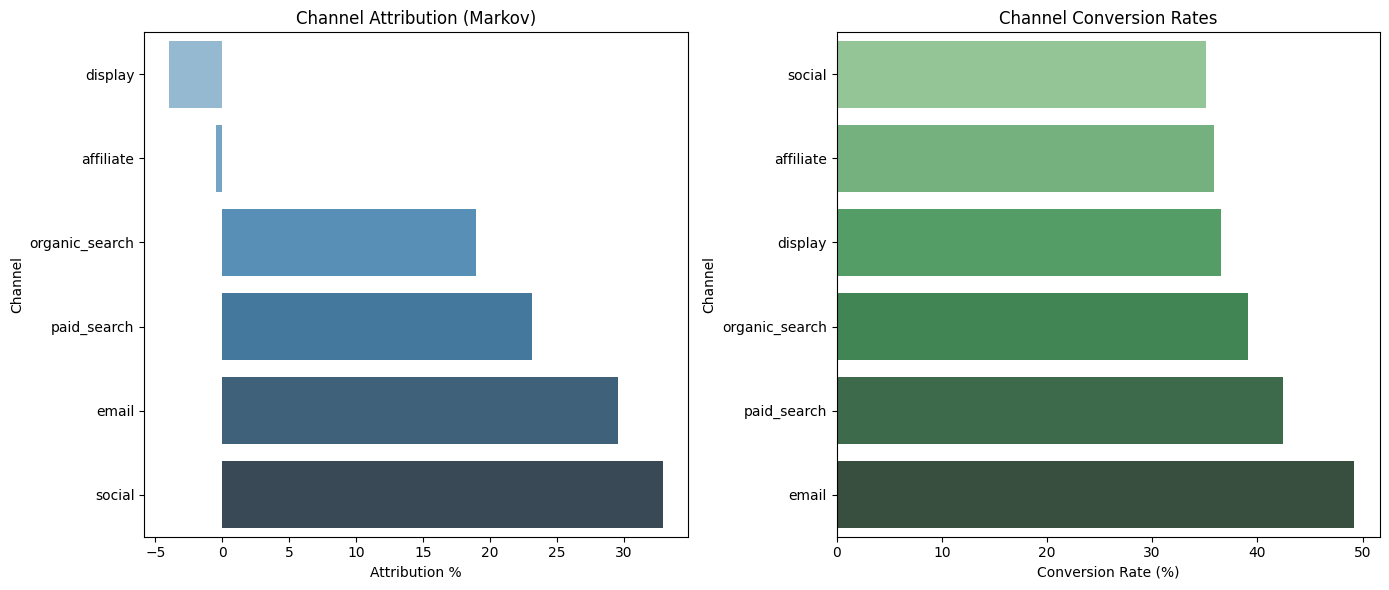

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Tuple, Dict, Any
from collections import defaultdict


class MarkovAttributionModel:
    """
    A Markov-based approach to channel attribution.

    This class builds a transition matrix from a set of customer journeys.
    Each journey is a list of channel names (plus a 'conversion' label at the end if applicable).

    States:
      - 'start': Beginning of the journey
      - 'conversion': Absorbing state if the customer converts
      - 'null': Absorbing state if the customer does not convert
      - Other channels: Non-absorbing states

    The model calculates an overall conversion probability and
    computes removal effects to determine the contribution of each channel.
    """

    def __init__(self, max_iterations: int = 500, tolerance: float = 1e-7) -> None:
        """
        Parameters
        ----------
        max_iterations : int
            Maximum number of iterations for the iterative state update.
        tolerance : float
            Convergence threshold for iterative Markov chain probability updates.
        """
        self.transition_matrix: np.ndarray | None = None
        self.channels: List[str] | None = None
        self.removal_effects: Dict[str, float] = {}
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def _create_transition_matrix(self, journeys: List[List[str]]) -> np.ndarray:
        """
        Build a transition probability matrix from a list of journeys.

        Parameters
        ----------
        journeys : List of customer journeys (lists of channel names).
                   A journey may optionally end with 'conversion'.

        Returns
        -------
        np.ndarray
            2D transition probability matrix of shape (n_channels, n_channels).
        """
        # Collect all channels, plus the special states
        all_channels = {'start', 'conversion', 'null'}
        for journey in journeys:
            all_channels.update(journey)

        # Sort channels for consistency
        self.channels = sorted(all_channels)
        channel_to_idx = {ch: i for i, ch in enumerate(self.channels)}
        n_channels = len(self.channels)

        # Initialize a count-based transition matrix
        transitions = np.zeros((n_channels, n_channels), dtype=float)

        # Build transition counts from each journey
        for journey in journeys:
            if not journey:
                continue

            # Transition from 'start' to first channel
            start_idx = channel_to_idx['start']
            first_idx = channel_to_idx[journey[0]]
            transitions[start_idx, first_idx] += 1

            # Intermediate channel-to-channel transitions
            for i in range(len(journey) - 1):
                current_idx = channel_to_idx[journey[i]]
                next_idx = channel_to_idx[journey[i + 1]]
                transitions[current_idx, next_idx] += 1

            # Last transition: channel -> conversion or channel -> null
            last_idx = channel_to_idx[journey[-1]]
            if journey[-1] == 'conversion':
                transitions[last_idx, channel_to_idx['null']] += 1
            else:
                transitions[last_idx, channel_to_idx['conversion']] += 1

        # Convert counts to probabilities row-wise
        row_sums = transitions.sum(axis=1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            transition_matrix = np.divide(transitions, row_sums, where=(row_sums != 0))

        self.transition_matrix = transition_matrix
        return transition_matrix

    def _calculate_conversion_probability(self, transition_matrix: np.ndarray) -> float:
        """
        Compute the overall conversion probability by repeatedly multiplying
        the state vector until it converges or until max_iterations is reached.

        Parameters
        ----------
        transition_matrix : np.ndarray
            Transition probability matrix for all channels including 'start', 'conversion', 'null'.

        Returns
        -------
        float
            Probability of eventually reaching the 'conversion' state.
        """
        if self.channels is None:
            raise ValueError("Channels are not initialized. Call _create_transition_matrix() first.")

        channel_to_idx = {ch: i for i, ch in enumerate(self.channels)}
        n_channels = len(self.channels)

        # Start in the 'start' state with probability 1
        state = np.zeros(n_channels, dtype=float)
        state[channel_to_idx['start']] = 1.0

        for _ in range(self.max_iterations):
            new_state = state @ transition_matrix
            if np.allclose(state, new_state, atol=self.tolerance):
                break
            state = new_state

        return state[channel_to_idx['conversion']]

    def calculate_attribution(self, journeys: List[List[str]]) -> Dict[str, float]:
        """
        Calculate Markov-based attribution for each channel by computing the
        'removal effect': difference in overall conversion probability when
        each channel is effectively removed.

        Parameters
        ----------
        journeys : List of journeys (each a list of channels).

        Returns
        -------
        Dict[str, float]
            Mapping of channel -> percentage contribution (sum = 100).
        """
        # Base transition matrix and base conversion probability
        base_matrix = self._create_transition_matrix(journeys)
        base_conv_prob = self._calculate_conversion_probability(base_matrix)

        # Calculate removal effect for each channel
        self.removal_effects.clear()
        if not self.channels:
            return {}

        for channel in self.channels:
            if channel in ['start', 'conversion', 'null']:
                continue  # We do not remove special states

            # Copy the base matrix and "remove" transitions from this channel
            mod_matrix = base_matrix.copy()
            channel_idx = self.channels.index(channel)

            # Remove all outgoing transitions from this channel
            mod_matrix[channel_idx, :] = 0.0

            # Calculate new conversion probability
            mod_conv_prob = self._calculate_conversion_probability(mod_matrix)

            # Removal effect ratio
            removal_effect = (base_conv_prob - mod_conv_prob) / base_conv_prob if base_conv_prob else 0.0
            self.removal_effects[channel] = removal_effect

        # Normalize effects to get percentages
        total_effect = sum(self.removal_effects.values())
        if total_effect > 0:
            return {
                ch: round((eff / total_effect) * 100, 2)
                for ch, eff in self.removal_effects.items()
            }
        else:
            return {ch: 0.0 for ch in self.removal_effects}


class EcommerceMarkovAttribution:
    """
    Synthetic e-commerce scenario demonstrating Markov-based attribution.

    This class:
      1. Generates user journeys with multiple channels.
      2. Stores each touchpoint with timestamps, conversion flags, and optional revenue.
      3. Analyzes journeys with a Markov model to get channel-level attribution.
    """

    def __init__(self) -> None:
        # Common channels in an e-commerce setting
        self.channels = [
            'paid_search', 'organic_search', 'email',
            'social', 'display', 'affiliate'
        ]

        # Example average revenue values associated with each channel
        self.conversion_value = {
            'paid_search': 100,
            'organic_search': 85,
            'email': 120,
            'social': 75,
            'display': 90,
            'affiliate': 110
        }

    def generate_realistic_journey(self) -> Tuple[List[str], List[datetime], bool]:
        """
        Generate a single synthetic but somewhat realistic customer journey.

        Returns
        -------
        journey : List[str]
            Sequence of channel names, possibly ending with 'conversion'.
        timestamps : List[datetime]
            Timestamp for each channel interaction.
        converts : bool
            Whether this journey resulted in a conversion.
        """
        # Channel probabilities based on position in journey
        first_touch_probs = {
            'paid_search': 0.35,
            'organic_search': 0.25,
            'social': 0.20,
            'display': 0.15,
            'affiliate': 0.05
        }
        mid_touch_probs = {
            'paid_search': 0.20,
            'organic_search': 0.15,
            'email': 0.25,
            'social': 0.20,
            'display': 0.10,
            'affiliate': 0.10
        }
        last_touch_probs = {
            'paid_search': 0.25,
            'organic_search': 0.15,
            'email': 0.30,
            'social': 0.15,
            'display': 0.05,
            'affiliate': 0.10
        }

        # Determine number of touches (1 to 5)
        length = np.random.choice([1, 2, 3, 4, 5], p=[0.3, 0.3, 0.2, 0.15, 0.05])

        journey = []
        timestamps = []
        base_time = datetime.now()

        for i in range(length):
            if i == 0:
                # First touch
                channel = np.random.choice(
                    list(first_touch_probs.keys()),
                    p=list(first_touch_probs.values())
                )
            elif i == length - 1:
                # Last touch
                channel = np.random.choice(
                    list(last_touch_probs.keys()),
                    p=list(last_touch_probs.values())
                )
            else:
                # Mid-journey
                channel = np.random.choice(
                    list(mid_touch_probs.keys()),
                    p=list(mid_touch_probs.values())
                )

            # Generate a timestamp, typically a few hours after the previous one
            if i == 0:
                timestamp = base_time
            else:
                hours_gap = np.random.exponential(24)  # average 24-hour gap
                timestamp = timestamps[-1] + timedelta(hours=hours_gap)

            journey.append(channel)
            timestamps.append(timestamp)

        # Decide conversion based on channel presence and journey length
        conversion_probability = 0.2  # base conversion rate

        if 'email' in journey:
            conversion_probability += 0.15
        if 'paid_search' in journey:
            conversion_probability += 0.10
        if 'organic_search' in journey:
            conversion_probability += 0.05
        if length >= 3:
            conversion_probability += 0.10

        converts = np.random.rand() < conversion_probability
        if converts:
            journey.append('conversion')

        return journey, timestamps, converts

    def generate_dataset(
        self,
        n_customers: int = 1000
    ) -> Tuple[pd.DataFrame, List[List[str]]]:
        """
        Generate a dataset of multiple journeys for n_customers.

        Parameters
        ----------
        n_customers : int
            Number of customer journeys to generate.

        Returns
        -------
        pd.DataFrame
            DataFrame of touchpoints with columns:
                ['customer_id', 'channel', 'timestamp', 'touch_point', 'converted', 'revenue'].
        List[List[str]]
            List of all journeys in channel form, including 'conversion' if applicable.
        """
        all_touchpoints = []
        journeys: List[List[str]] = []
        customer_id = 0

        for _ in range(n_customers):
            journey, timestamps, converted = self.generate_realistic_journey()
            journeys.append(journey)

            # Convert each step in the journey to a row in the touchpoints list
            # If 'conversion' is appended, skip that in the iteration so we don't store a pseudo channel row
            active_steps = journey[:-1] if converted else journey
            for i, (channel, timestamp) in enumerate(zip(active_steps, timestamps)):
                # If converted, revenue is attributed to the last channel's row
                last_channel_before_conversion = (converted and i == len(active_steps) - 1)
                revenue = self.conversion_value[channel] if last_channel_before_conversion else 0

                all_touchpoints.append({
                    'customer_id': customer_id,
                    'channel': channel,
                    'timestamp': timestamp,
                    'touch_point': i + 1,
                    'converted': converted,
                    'revenue': revenue
                })

            customer_id += 1

        df = pd.DataFrame(all_touchpoints)
        return df, journeys

    def analyze_journeys(
        self,
        df: pd.DataFrame,
        journeys: List[List[str]]
    ) -> Dict[str, Any]:
        """
        Analyze the generated journeys and return various metrics.

        Parameters
        ----------
        df : pd.DataFrame
            Touchpoints DataFrame.
        journeys : List[List[str]]
            List of all journeys in channel form.

        Returns
        -------
        Dict[str, Any]
            A dictionary containing overall metrics, channel-level metrics,
            and Markov attribution percentages.
        """
        total_customers = df['customer_id'].nunique()
        total_conversions = df.loc[df['converted'], 'customer_id'].nunique()
        conversion_rate = round((total_conversions / total_customers * 100), 2)

        # Summaries grouped by channel
        channel_metrics = df.groupby('channel').agg({
            'customer_id': 'count',
            'converted': 'sum',
            'revenue': 'sum'
        })
        channel_metrics.rename(columns={'customer_id': 'touch_count'}, inplace=True)

        # Calculate channel-level conversion rate
        channel_metrics['conversion_rate'] = (
            channel_metrics['converted'] / channel_metrics['touch_count'] * 100
        ).round(2)

        # Markov-based attribution
        markov_model = MarkovAttributionModel()
        attribution = markov_model.calculate_attribution(journeys)

        # Add attribution data to channel_metrics
        channel_metrics['attribution_percentage'] = channel_metrics.index.map(
            lambda ch: attribution.get(ch, 0.0)
        )

        return {
            'overall_metrics': {
                'total_customers': total_customers,
                'total_conversions': total_conversions,
                'conversion_rate': conversion_rate
            },
            'channel_metrics': channel_metrics,
            'attribution': attribution
        }


def plot_results(metrics: Dict[str, Any]) -> plt.Figure:
    """
    Create visualizations of channel-level results.

    Parameters
    ----------
    metrics : Dict[str, Any]
        A dictionary with keys ['channel_metrics', 'overall_metrics', 'attribution']
        as returned by `analyze_journeys`.

    Returns
    -------
    plt.Figure
        A matplotlib Figure object containing the plots.
    """
    channel_metrics = metrics['channel_metrics']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Attribution percentages
    attribution_data = channel_metrics['attribution_percentage'].sort_values(ascending=True)
    sns.barplot(
        x=attribution_data.values,
        y=attribution_data.index,
        ax=ax1,
        palette='Blues_d'
    )
    ax1.set_title('Channel Attribution (Markov)')
    ax1.set_xlabel('Attribution %')
    ax1.set_ylabel('Channel')

    # Plot 2: Conversion rates by channel
    conversion_data = channel_metrics['conversion_rate'].sort_values(ascending=True)
    sns.barplot(
        x=conversion_data.values,
        y=conversion_data.index,
        ax=ax2,
        palette='Greens_d'
    )
    ax2.set_title('Channel Conversion Rates')
    ax2.set_xlabel('Conversion Rate (%)')
    ax2.set_ylabel('Channel')

    fig.tight_layout()
    return fig


if __name__ == "__main__":
    # Instantiate the main e-commerce Markov attribution class
    model = EcommerceMarkovAttribution()

    # Generate synthetic data
    print("Generating e-commerce customer journeys...")
    touchpoints_df, journeys = model.generate_dataset(n_customers=5000)

    # Analyze the data
    print("Analyzing customer journeys...")
    metrics = model.analyze_journeys(touchpoints_df, journeys)

    # Print results
    print("\nOverall Metrics:")
    for k, v in metrics['overall_metrics'].items():
        print(f"{k}: {v}")

    print("\nChannel Metrics:")
    print(metrics['channel_metrics'].round(2))

    # Plot results
    fig = plot_results(metrics)
    plt.show()
